In [ ]:
# for collab users
%pip install py-pde

!git clone https://github.com/mexalon/gg_modeling.git
!cp -r /content/gg_modeling/layered_k.npy /content/

In [1]:
import numpy as np
from scipy.special import expit
import os
from tqdm.notebook import tqdm
import h5py

from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

from pde import MemoryStorage, PDEBase, FieldCollection, ScalarField, VectorField, MemoryStorage, CartesianGrid

# from plotting import plot_fracture_prob, plot_press, plot_sat

In [30]:
class Two_Phase_Gas_Grav(PDEBase):
  
    def __init__(self):
        super().__init__()
        self.eps = 1e-2  # just 0.01
        self.shape = (40, 100, 2) # points
        self.sides = ((0, 4), (0, 10), (0, 1)) # meters
        
        self.O = (2, 2, 0.5) # центр области с газогидратом, метры
        self.R0 = 1 # радиус области разложения газогидрата, метры

        self.t_scale = 3600 # sec - масштаб времени

        # параметры среды
        self.k = 0.01 # Darcy проницаемсть
        self.m = 0.5 # поистость

        # параметры флюидов
        self.ro_gas = 1.28 # начальная плотность газа kg/m3
        self.ro_liq = 1000 # плотность жидкоти kg/m3

        self.nu_gas = 0.01 / self.t_scale # вязкость газа cP
        self.nu_liq = 1 / self.t_scale # вязкость жидкости cP

        # давление
        self.P0 = 0.2 # MPa press - давление на нулевой глубине - 20 метров = 0.2 Мпа
        self.P_gas = 0.0 # MPa давление в газовой области (превышение над гидростатическим)
        self.Pc = 0.06 # капиллярное давление, Pc = alpha/r alpha - коэффициент пов. нат., r - характерный размер пор. можно оценить r~sqrt(k/m)

        # начальная насыщенность
        self.s0 = 0.05 # во всей области
        self.s_star = 0.2 # миниммальная подвижная насыщенность 
        self.s_gas = self.s_star # начальная насыщенность в области с газом (равна s_sta чтобы не ждать, когда газ до неё докопится)

        # пороговый градиент
        self.G = 0.01 # МПа/м  - равен гидростатики например

        # распределённый источник газа 
        self.q = 2 * 1e-6 * self.t_scale # это dro/dt, если выделение газа 1 кг в куб. метре в секунду, то q=1 кг/м3*сек

                # generate grid
        self.grid = CartesianGrid(self.sides, self.shape)  

        # выделенная область с газом
        xyz = self.grid.cell_coords # координаты сетки
        # xh, yh, zh = np.where(self.grid.distance(xyz, self.O) <= self.R0) # координаты области с газогидратом
        xh, yh, zh = np.where((xyz[:,:,:,1] <= self.O[1] + self.R0) & (xyz[:,:,:,1] >= self.O[1] - self.R0)) # координаты области с газогидратом

        # поле проницаемости со случайными вариациями 
        rand_k = np.ones(self.shape) * self.k 
        rand_k[:,3:-3,:]  = rand_k[:,3:-3,:] + 0.2 * np.random.randn(*(rand_k[:,3:-3,:].shape)) * self.k 
        self.k_field = ScalarField(self.grid, data=rand_k)

        # g field  - поле силы тяжести
        g = np.zeros((3,) + self.shape) # 
        g[1,:] = - 9.81 * 1e-6 # gravity by Y ax; 1e-6 - to be good with pressire in MPa
        self.g_field = VectorField(self.grid, data=g) # grav field

        # hydrostatic field - гидростатическое поле давления
        self.ro_g_h = self.get_ro_g_h(self.ro_liq)

        # Pore initial field - начальное поровое давление газа
        P_ini = np.ones(self.shape) * self.ro_g_h + self.P0 + self.Pc # давление во всём объёме
        P_ini[xh, yh, zh] = P_ini[xh, yh, zh] + self.P_gas # давлеие в области с газом 
        self.p_ini_field = ScalarField(self.grid, data=P_ini) # MPa

        # s_gas initial field - начальное поле насыщенности газом
        s_ini = np.ones(self.shape) * self.s0 # насыщенность во всём объёме
        s_ini[xh, yh, zh] = self.s_gas # насыщенность в области с газом 
        self.s_ini_field = ScalarField(self.grid, data=s_ini) 

        # source field - распределённый источник газа. q по сути это dro/dt в области выделения, если выделение газа 1 кг в куб. метре в секунду, то q=1 кг/м3*сек
        q = np.zeros(self.shape)
        q[xh, yh, zh] = self.q 
        self.source_field = ScalarField(self.grid, data=q) 

        # boundary condition
        # was before
        # self.p_bc = [{'derivative': 0}, [{'curvature': 0}, {'value':self.P0}], {'derivative': 0}] # граничное условие на давление (непроницаемые границы, сверху сток)
        # self.flow_bc = [{'value': 0}, [{'derivative': 0}, {'derivative': 0}], {'value': 0}] # граничные условия на поток на границах (непроницаемые границы, сверху сток)
        ro_g = 9.81 * 1e-6 * self.ro_liq
        self.p_liq_bc = [{'derivative': 0}, [{'derivative': ro_g}, {'value':self.P0}], {'derivative': 0}] # граничное условие на давление (непроницаемые границы, сверху сток)
        self.p_gas_bc = [{'derivative': 0}, [{'derivative': ro_g}, {'value':self.P0 + self.Pc}], {'derivative': 0}]
        self.flow_bc = [{'value': 0}, [{'value': 0}, {'derivative': 0}], {'value': 0}] # граничные условия на поток на границах (непроницаемые границы, сверху сток)


    # метод для вычисления гидростатического давления, плотность должна быть в кг/м3
    def get_ro_g_h(self, ro):
        ro_g = self.g_field.to_scalar().data * ro * self.grid.cell_volume_data[1] 
        ro_g_h = np.cumsum(ro_g, axis=1) - ro_g/2 # гидростатическое давление, среднее по ячейке, поэтому минус половина ro_g
        ro_g_h = np.flip(ro_g_h, axis=1) # Y направлена снизу вверх
        return ro_g_h

    # относительные фазовые проницаемости: 
    # для газа
    def k_s_gas(self, s):
        sd = s.data
        s_star = np.ones_like(sd) * self.s_star # минимальная подвижная насыщенность, при меньшей проницаемость ноль, при большей - линейная
        ks = (sd-s_star)/(1-s_star)
        ks[sd < s_star] = 0
        # ks = np.max((ks, np.zeros_like(sd)), axis=0) # при меньшей проницаемость ноль, при большей - линейная
        return ScalarField(self.grid, data=ks)
    
    # для жидкости
    def k_s_liq(self, s):
        return s # просто s, смачивающая фаза
        
    # обобщённый закон Дарси для Газа
    def darcy_gas(self, grad_P, ro, nu, s):
        a = 1e-3 * self.k_field * self.k_s_gas(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        w = - a * (grad_P - ro * g) # Darcy law
        return w
    
    # обобщённый закон Дарси для Жидкости
    def darcy_liq(self, grad_P, ro, nu, s):
        a = 1e-3 * self.k_field * self.k_s_liq(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        w = - a * (grad_P - ro * g) # Darcy law
        return w
    
    # обобщённый закон Дарси для жидкости с пороговым градиентом G (пока постоянным)
    def darcy_liq_TPG(self, grad_P, ro, nu, s):
        a = 1e-3 * self.k_field * self.k_s_liq(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        grad = grad_P - ro * g # обычный градиент
        gd = grad.to_scalar().data # модуль вектора обычного градиента
        Gd = np.ones_like(gd) * self.G # модуль G
        k_tpg = np.max((1 - Gd/gd, np.zeros_like(gd)), axis=0) # ноль если градиент меньше G, градиент минус G, если больше
        w = - a * k_tpg * grad  # TPG + Darcy law
        return w
    
    # уравнение состояния для газа
    def P(self, ro):
        P = ro * self.P0 / self.ro_gas
        return P
    
    def ro(self, P):
        ro = P * self.ro_gas / self.P0
        return ro    
    
    # давление в жидкости с учётом капиллярного давления (пока постоянного)
    def get_P_liq(self, P_gas):
        p_gas = P_gas.data
        p_liq_ini = self.ro_g_h + self.P0
        p_c = self.Pc
        p_liq = np.max((p_gas - p_c, p_liq_ini), axis=0)
        return ScalarField(self.grid, data=p_liq) 
    
    # делаем насыщенность от eps до 1-eps 
    def check_s(self, s):
        sd = s.data
        eps = np.ones_like(sd) * self.eps
        new_s = np.max((sd, eps), axis=0)
        new_s = np.min((new_s, 1-eps), axis=0)
        return ScalarField(self.grid, data=new_s)
    
    # делаем, чтобы изменение насыщенности было в рамках [eps, 1-eps] 
    def check_ds_dt(self, s, ds_dt):
        sd = s.data
        ds_dtd = ds_dt.data
        eps = np.ones_like(sd) * self.eps
        new_ds_dt = np.zeros_like(sd)
        valid_ds_dt = (sd + ds_dtd > eps) & (sd + ds_dtd < 1 - eps)
        new_ds_dt[valid_ds_dt] = ds_dtd[valid_ds_dt]
        return ScalarField(self.grid, data=new_ds_dt)

    # вся магия тут
    def evolution_rate(self, state, t=0):
        ''' Basniev pp.256'''
        P_gas, s_gas = state # искомые поля - давление и насыщенность газом
        s_gas = self.check_s(s_gas) # на всякий случай обрезаем насыщенность, чтобы не выходила за границы разумного
        
        P_liq = self.get_P_liq(P_gas) # давление в жидкости
        s_liq = 1-s_gas # насыщенность жидкости = 1 - s газа

        ro = self.ro(P_gas) # распреджеление плотности газа исходя из давления

        grad_P_gas = P_gas.gradient(self.p_gas_bc) # градиент давления в газе
        grad_P_liq = P_liq.gradient(self.p_liq_bc) # градиент давления в жидкости

        w1 = self.darcy_gas(grad_P_gas, self.ro_liq, self.nu_gas, s_gas) # скорость фильтрации газа. 
        # тут плотность ноль, чтобы пренебречь гидростатикой внутри газа, так как она много меньше по сравнению с гидростатикой жидкости 

        w2 = self.darcy_liq(grad_P_liq, self.ro_liq, self.nu_liq, s_liq) # скорость фильтрации жидкости по дарси, либо 
        # w2 = self.darcy_liq_TPG( grad_P_liq, self.ro_liq, self.nu_liq, s_liq) # по Дарси с пороговым градиентом

        ds_liq_dt = - (1/self.m) * w2.divergence(self.flow_bc) # уравнение на изменение насыщенности жидкости
        ds_gas_dt = - ds_liq_dt # сколько ушло, столько и пришло
        ds_gas_dt = self.check_ds_dt(s_gas, ds_gas_dt) # на всякий случай обрезаем изменение насыщенности, чтобы она не выходила за границы разумного
 
        source = self.source_field # поле источника газа
        dro_dt = - (1/s_gas) * ((1/self.m) * (ro * w1).divergence(self.flow_bc) + ro * ds_gas_dt) + source # пьезопроводность (относительно плотности газа)
        dP_dt = self.P(dro_dt) # переводим изменение плотности в изменение давления
   
        return FieldCollection([dP_dt, ds_gas_dt])

In [31]:
eq = Two_Phase_Gas_Grav()

rand_k = np.load('layered_k.npy')
k_field = ScalarField(eq.grid, data=rand_k)
eq.k_field = k_field

ini_state = FieldCollection([eq.p_ini_field, eq.s_ini_field])
storage = MemoryStorage()
# t_tange относительно self.t_scale - масштаба времени

res = eq.solve(ini_state, t_range=150, adaptive=True, tracker=['progress', 'plot', storage.tracker(1)])
press, sat = np.array(storage.data)[:,0,...],  np.array(storage.data)[:,1,...]

# saving data
exp_name = 'q_3_5e-6'

CURR_DIR = os.getcwd()
dir_path = Path(f'{CURR_DIR}/results_{exp_name}___{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}')
dir_path.mkdir(parents=True, exist_ok=True)
np.save(f'{dir_path}/press', press)
np.save(f'{dir_path}/sat', sat)

  0%|          | 0/150.0 [00:00<?, ?it/s]

Output()

In [32]:
# eq = Two_Phase_Gas_Grav()

'''
Считаем возможность возникновение выброса
'''

P_gas = np.load(f'{dir_path}/press.npy')
s = np.load(f'{dir_path}/sat.npy')

ro_solid = 2700 # kg/m3 плотность песка

liq_ro_g_h =  eq.get_ro_g_h(eq.ro_liq) + eq.P0 # началльное давление в воде (гидростатика, прибавляем давление столба воды сверху дна)
solid_ro_g_h = eq.get_ro_g_h(ro_solid) + eq.P0 # литостатика

P_liq = np.max((P_gas - eq.Pc, np.ones_like(P_gas)*liq_ro_g_h), axis=0) # давление в воде с учётом текуущего давления газа (либо гидростатика, либо давление газа минус капиллярное давление, смотря что болше)

'''
Критерий выброса - превышение порового давления над литостатикой.
Поровое давление предлагаю считать среднее между газом и жидкостью с весом насыщенностию
Ну то есть если есьт некий объём среды, часть которого занята газом, а часть жидкостью, 
то на скелет действует давление газа там где газ, и жидкости там, где жидкость, пропорционально их долям, а это иесть насыщенность.
Как на самом деле надо считать - мне не очень непонятно. В реальности вода смачивает скелет, то есть он контактирует только с водой. 
Но в концепции фазовых проницаемостей мы считаем, что флюиды каждый по отдельности взаимодействуют только со скелетом, а не между собой, 
поэтому мы можем применять дари для каждой из фаз.
Вобщем тут вопрос философский. 
'''
sigma = 0.005 # сигма разницы порового и литостатики, при которых начнётся разрушение, МПа
# pore_press = s * P_gas + (1-s) * P_liq # средневзвешенное поровое давление
pore_press =  P_liq # давление жидкости

# вероятность возникновения разрушения
fracture_prob = expit((pore_press - solid_ro_g_h)/sigma) # логистичекая сигмоида от отношения порового и литостатики, чтобы вероятность на графике была красивее
'''
expit(x) = 1/(1+exp(-x))
expit(0) = 0.5
expit(3) = 0.95
то естсь при отношении порового и литостатики, равного 1 вероятность 0.5, а при разнице плюс мину 3 сигма вероятность будет от 0.05 до 0.95 примерно:

Пример для понимания - 
sigma = 0.02
x = np.linspace(0,2,100)
fr_prob = expit((x-1)/(sigma))

fig, ax = plt.subplots()
ax.plot(x, fr_prob )
'''
pass

In [27]:
# funcs for plotting results

def plot_press(eq, data, mask=None, vmin_vmax=None, save=False, title=None, fname='gas_pore_pressure'):
    cmap = mpl.cm.viridis
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    ax.imshow(data[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)

    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')

    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Pore pressure, MPa')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()


def plot_sat(eq, data, mask=None, vmin_vmax=None, save=False, title=None, fname='gas_saturation'):
    cmap = mpl.cm.viridis
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    ax.imshow(data[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)

    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Gas saturation')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()


def plot_fracture_prob(eq, data,  mask=None, vmin_vmax=None, save=False, title=None, fname='fracture_prob'):
    cmap = mpl.cm.plasma

    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))  # km

    fig, ax = plt.subplots(figsize=(3, 4), layout="constrained")

    to_plot = data[:, :, 0].transpose()

    ax.imshow(to_plot, extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap=cmap, norm=norm)
    
    # plot fracture
    if mask is not None:
        ax.imshow(mask[:, :, 0].transpose(), extent=[x_ax[0], x_ax[-1], y_ax[-1], y_ax[-0]], origin='lower', cmap="cool", alpha=mask[:, :, 0].transpose()) # mask

    if title:
        ax.set_title(title)
    else:
        ax.set_title('XZ plane')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Depth, m')



    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='vertical', label='Fracture probability')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()

def plot_press_curves(eq, press, save=False, fname='pressure_curves'):
    steps = press.shape[0]
    fig, ax = plt.subplots(figsize=(3, 4))
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=0, vmax=steps * eq.t_scale/3600)

    _ , y_ax, _ = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))
    depth = np.flip(y_ax)

    ax.invert_yaxis()
  
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='horizontal', location='top', label='Time, h')

    ax.set_xlabel('Gas Pressure, MPa')
    ax.set_ylabel('Depth, m')

    for ii in tqdm(range(steps)):
        hh = ii * eq.t_scale/3600
        if ii%10 == 0:
          mean_data = np.mean(press[ii], axis = (-3, -1))
          plt.plot(mean_data, depth, color=cmap(norm(hh)))

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()

def plot_sat_curves(eq, sat, save=False, fname='sat_curves'):
    steps = sat.shape[0]
    fig, ax = plt.subplots(figsize=(3, 4))
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=0, vmax=steps * eq.t_scale/3600)

    _ , y_ax, _ = (np.linspace(s[0], s[1], sh) for sh, s in zip(eq.shape, eq.sides))
    depth = np.flip(y_ax)

    ax.invert_yaxis()
  
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, orientation='horizontal', location='top', label='Time, h')

    ax.set_xlabel('Gas Saturation')
    ax.set_ylabel('Depth, m')

    for ii in tqdm(range(steps)):
        hh = ii * eq.t_scale/3600
        if ii%10 == 0:
          mean_data = np.mean(sat[ii], axis = (-3, -1))
          plt.plot(mean_data, depth, color=cmap(norm(hh)))

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # plt.show()
    plt.close()
    

In [33]:
# pics for gifs

# dir_path = ''

# create some folders
pic_path = Path(f'{dir_path}/pics/')

press_path = Path(f'{dir_path}/pics/press/')
press_path.mkdir(parents=True, exist_ok=True)

sat_path = Path(f'{dir_path}/pics/sat/')
sat_path.mkdir(parents=True, exist_ok=True)

prob_path = Path(f'{dir_path}/pics/fr_prob/')
prob_path.mkdir(parents=True, exist_ok=True)

# common vmin vmax
press_vmin_vmax=(np.min(P_gas), np.max(P_gas))
sat_vmin_vmax=(np.min(s), np.max(s))

for ii in tqdm(range(P_gas.shape[0])):

    tt = ii * eq.t_scale/3600 # hours
    
    mask = (fracture_prob[ii]>=0.5).astype('float')
    
    plot_press(eq, P_gas[ii], mask=mask, vmin_vmax = press_vmin_vmax, title=f'T = {tt} h', save=True, fname=f'{press_path}/press_{ii}')
    plot_sat(eq, s[ii], mask=mask, vmin_vmax = sat_vmin_vmax, title=f'T = {tt} h', save=True, fname=f'{sat_path}/sat_{ii}')
    plot_fracture_prob(eq, fracture_prob[ii], mask=mask, title=f'T = {tt} h', save=True, fname=f'{prob_path}/fr_prob_{ii}')

plot_press_curves(eq, P_gas, save=True, fname=f'{pic_path}/press_curves') 
plot_sat_curves(eq, sat, save=True, fname=f'{pic_path}/sat_curves')

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

### Дальше всякие рабочие моменты для тестирования, не для публикации

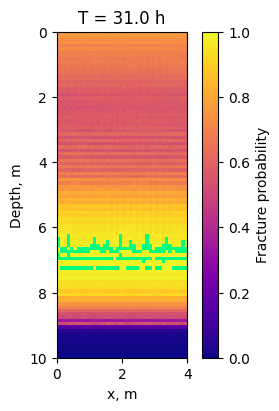

In [144]:

plot_fracture_prob(eq, fracture_prob[105], title=f'T = {tt} h', save=True, fname=f'{fpath}/fr_p_{ii}')

In [ ]:
yield_path = 'delete_me.h5' # saving
with h5py.File(yield_path, 'w') as targ:
    perm_h5_set = targ.create_dataset("press",  data=press) # 
    dens_h5_set = targ.create_dataset("s",  data=sat)   

In [14]:
# генерируем слоистую проницаемость
def generate_and_save_k_field(eq):
    rand_k = np.ones(eq.shape) * eq.k
    rand_k[:,3:-3,:]  = rand_k[:,3:-3,:] + 0.1 * np.random.randn(*(rand_k[:,3:-3,:].shape)) * eq.k 
    lines = np.random.rand(1, rand_k.shape[1], 1)
    rand_k = rand_k * (1 + 0.3*(lines - 0.5))
    return rand_k

# один раз сгенерировать проницаемость
eq = Two_Phase_Gas_Grav() 
rand_k = generate_and_save_k_field(eq)
np.save('layered_k', rand_k)

# и потом подставлять её в уравнение для каждого расчёта
eq = Two_Phase_Gas_Grav() 
rand_k = np.load('layered_k.npy')
k_field = ScalarField(eq.grid, data=rand_k)
eq.k_field = k_field


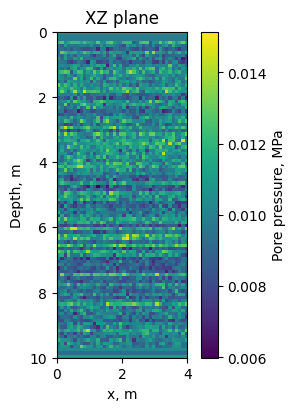

In [17]:
plot_press(eq, rand_k)

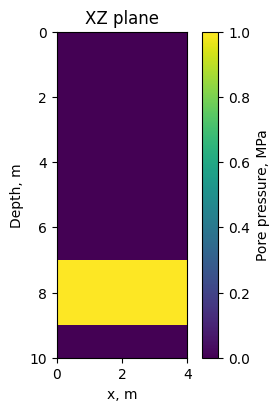

In [43]:
eq = Two_Phase_Gas_Grav() 

# выделенная область с газом
xyz = eq.grid.cell_coords # координаты сетки
# xh, yh, zh = np.where(self.grid.distance(xyz, self.O) <= self.R0) # координаты области с газогидратом
xh, yh, zh = np.where((xyz[:,:,:,1] <= eq.O[1] + eq.R0) & (xyz[:,:,:,1] >= eq.O[1] - eq.R0)) # координаты области с газогидратом

test = np.zeros(eq.shape)
test[xh, yh, zh] = 1
plot_press(eq, test)

In [41]:
xyz = eq.grid.cell_coords
np.where((xyz[:,:,:,1]<= eq.O[1] + eq.R0) & (xyz[:,:,:,1]>= eq.O[1] - eq.R0))

(array([ 0,  0,  0, ..., 39, 39, 39], dtype=int64),
 array([10, 10, 11, ..., 28, 29, 29], dtype=int64),
 array([0, 1, 0, ..., 1, 0, 1], dtype=int64))